In [1]:
import pandas as pd
import numpy as np
import microdf as mdf
import plotly.express as px
import statsmodels.api as sm
from ubicenter import format_fig

In [2]:
# Read data per person per year.
py = pd.read_csv("data/nys_cps.csv.gz")
py.columns = py.columns.str.lower()
py.inctot.replace({999999999: 0}, inplace=True)
py.adjginc.replace({99999999: 0}, inplace=True)
# 2014 was double-sampled.
py.loc[py.year == 2014, ["asecwt", "spmwt"]] /= 2
# ASEC shows survey year.
py.year -= 1

In [3]:
NYC_COUNTY = pd.DataFrame(columns=["fips", "county", "pop_m"])
NYS_FIPS = 36
# Per https://en.wikipedia.org/wiki/List_of_counties_in_New_York
NYC_COUNTY.loc["Manhattan"] = pd.Series({"fips": 61, "county": "New York", "pop_m": 1.632})
NYC_COUNTY.loc["Brooklyn"] = pd.Series({"fips": 47, "county": "Kings", "pop_m": 2.59})
NYC_COUNTY.loc["The Bronx"] = pd.Series({"fips": 5, "county": "Bronx", "pop_m": 1.435})
NYC_COUNTY.loc["Staten Island"] = pd.Series({"fips": 85, "county": "Richmond", "pop_m": 0.475})
NYC_COUNTY.loc["Queens"] = pd.Series({"fips": 81, "county": "Queens", "pop_m": 2.287})
NYC_COUNTY["full_fips"] = NYS_FIPS * 1000 + NYC_COUNTY.fips

py = py[py.county.isin(NYC_COUNTY.full_fips)][
    ["county", "asecwt", 'age', 'sex', 'race', 'hispan', 'inctot', 'spmwt', 'spmtotres', 'spmthresh',
       'spmfamunit', 'adjginc', 'ftotval', 'spmftotval', 'year', 'spmgeoadj']]
py["adult"] = py.age > 17
py["child"] = py.age <= 17
py["spmratio"] = py.spmtotres / py.spmthresh
py["poor"] = py.spmratio < 1
py["deep_poor"] = py.spmratio < 0.5
# py[]
NYC_COUNTY["asec_pop_m"] = NYC_COUNTY.full_fips.apply(
    lambda x: py[(py.county == x) & (py.year == py.year.max())].asecwt.sum() / 1e6
)
NYC_COUNTY

,fips,county,pop_m,full_fips,asec_pop_m
Manhattan,61,New York,1.632,36061,1.634743
Brooklyn,47,Kings,2.590,36047,2.634859
The Bronx,5,Bronx,1.435,36005,1.586280
Staten Island,85,Richmond,0.475,36085,0.497162
Queens,81,Queens,2.287,36081,1.869408


In [4]:
def year_stats(p):
    s = p[["spmfamunit", "year", "spmtotres", "spmthresh", "spmwt"]].drop_duplicates()
    return pd.Series({
        "spmgeoadj": mdf.weighted_mean(p, "spmgeoadj", "asecwt"),
        "poverty_rate": mdf.weighted_mean(p, "poor", "asecwt"),
        "deep_poverty_rate": mdf.weighted_mean(p, "deep_poor", "asecwt"),
        "poor_adults": mdf.weighted_sum(p[p.adult], "poor", "asecwt"),
        "deep_poor_adults": mdf.weighted_sum(p[p.adult], "deep_poor", "asecwt"),
        "child_poverty_rate": mdf.weighted_mean(p[p.child], "poor", "asecwt"),
        "child_deep_poverty_rate": mdf.weighted_mean(p[p.child], "deep_poor", "asecwt"),
        "adult_poverty_rate": mdf.weighted_mean(p[p.adult], "poor", "asecwt"),
        "adult_deep_poverty_rate": mdf.weighted_mean(p[p.adult], "deep_poor", "asecwt"),
        "poverty_gap": mdf.poverty_gap(s, "spmtotres", "spmthresh", "spmwt"),
        "squared_poverty_gap": mdf.squared_poverty_gap(s, "spmtotres", "spmthresh", "spmwt"),
        "deep_poverty_gap": mdf.deep_poverty_gap(s, "spmtotres", "spmthresh", "spmwt"),
        "gini": mdf.gini(s, "spmtotres", "spmwt"),
        "population": p.asecwt.sum(),
        "spm_units": s.spmwt.sum(),
        "survey_population": p.shape[0],
        "survey_spm_units": s.shape[0],
    })
year = py.groupby("year").apply(year_stats)
year


,spmgeoadj,poverty_rate,deep_poverty_rate,poor_adults,deep_poor_adults,child_poverty_rate,child_deep_poverty_rate,adult_poverty_rate,adult_deep_poverty_rate,poverty_gap,squared_poverty_gap,deep_poverty_gap,gini,population,spm_units,survey_population,survey_spm_units
year,,,,,,,,,,,,,,,,,
2009,1.171758,0.238819,0.077847,1406646.140,461700.23,0.285527,0.091285,0.225489,0.074012,7.551520e+09,1.246579e+14,2.339699e+09,0.477896,8018515.38,3462591.14,4011.0,1646.0
2010,1.171034,0.254766,0.083146,1525446.480,511316.47,0.304332,0.091854,0.240661,0.080667,7.682122e+09,1.083313e+14,1.993207e+09,0.455999,8142355.16,3535711.74,3892.0,1653.0
2011,1.177843,0.264718,0.091158,1643151.780,552227.18,0.303672,0.112016,0.253722,0.085271,8.933751e+09,1.399246e+14,2.562050e+09,0.474011,8304166.90,3540372.29,3888.0,1614.0
2012,1.185227,0.283449,0.085348,1724078.310,544069.96,0.346137,0.090276,0.266143,0.083987,9.191809e+09,1.415252e+14,2.657799e+09,0.495976,8266401.85,3654560.71,3741.0,1590.0
2013,1.197308,0.248841,0.080284,1598883.565,526017.99,0.259022,0.077976,0.245993,0.080929,8.501543e+09,1.264797e+14,2.303691e+09,0.477413,8317762.07,3775078.88,3761.0,1624.0
2014,1.205353,0.244156,0.061335,1634360.030,421724.70,0.238525,0.053827,0.245705,0.063401,8.251719e+09,1.313441e+14,2.311944e+09,0.476089,8481922.52,3664382.81,3714.0,1562.0
2015,1.212111,0.209054,0.055558,1332270.600,372160.26,0.251927,0.057029,0.197466,0.055161,6.836883e+09,1.113995e+14,1.917664e+09,0.453240,8570608.64,3675576.36,3327.0,1414.0
2016,1.216385,0.172255,0.048316,1129649.120,337656.81,0.184672,0.040192,0.168928,0.050493,5.796825e+09,9.590009e+13,1.688800e+09,0.478641,8479062.17,3684690.55,3288.0,1406.0
2017,1.214323,0.209325,0.047428,1310488.930,318786.72,0.273164,0.049709,0.192499,0.046827,6.427673e+09,8.833340e+13,1.421812e+09,0.493949,8601995.46,3834281.25,3017.0,1327.0


In [5]:
format_fig(px.line(year.deep_poverty_rate))

<AxesSubplot:xlabel='year'>

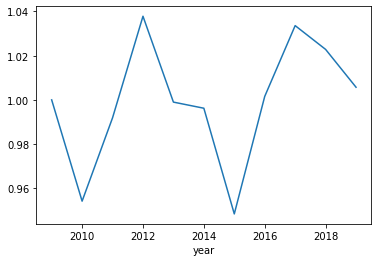

In [6]:
(year.gini / year.gini.iloc[0]).plot()

In [7]:
def trend(col):
    return sm.OLS(year[col] / year[col].iloc[0], sm.add_constant(year.index)).fit().params

trend("gini")

const   -4.589639
x1       0.002775
dtype: float64

In [8]:
sm.OLS(year.squared_poverty_gap / year.squared_poverty_gap.iloc[0], sm.add_constant(year.index)).fit().summary()

/home/mghenis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=11



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     squared_poverty_gap   R-squared:                       0.442
Model:                             OLS   Adj. R-squared:                  0.381
Method:                  Least Squares   F-statistic:                     7.143
Date:                 Mon, 14 Jun 2021   Prob (F-statistic):             0.0255
Time:                         12:35:13   Log-Likelihood:                 9.3529
No. Observations:                   11   AIC:                            -14.71
Df Residuals:                        9   BIC:                            -13.91
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.5923     21.950      2.715      0.024       9.938     109.247
x1            -0.0291      0.011     -2.673      0.026      -0.054      -0.004
==============================================================================
Omnibus:                        1.153   Durbin-Watson:                   1.323
Prob(Omnibus):                  0.562   Jarque-Bera (JB):                0.723
Skew:                          -0.192   Prob(JB):                        0.697
Kurtosis:                       1.804   Cond. No.                     1.28e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
py.groupby("year").size()

year
2009    4011
2010    3892
2011    3888
2012    3741
2013    3761
2014    3714
2015    3327
2016    3288
2017    3017
2018    3274
2019    2712
dtype: int64

In [10]:
# Use three years of data to smooth out given small sample size.
p = py[py.year.isin([2017, 2018, 2019])].copy()
p[["asecwt", "spmwt"]] /= 3

In [11]:
BUDGET = 1e9  # $1 billion.
REACH = 500e3  # 500,000 adult New Yorkers.

P_S_MERGE_COLS = ["year", "spmfamunit"]
SPMU_COLS = ["spmtotres", "spmthresh", "spmratio", "spmwt", "spmftotval"]
SPMU_AGGS = ["adult", "child"]

s = p.groupby(P_S_MERGE_COLS + SPMU_COLS)[SPMU_AGGS].sum().reset_index()

In [12]:
def phase_out(amount, rate, respect_to):
    return np.maximum(0, amount - respect_to * rate)



def policy(pov_ratio_guarantee, phase_out_rate):
    """ Computes features of a negative income tax.

    Args:
        pov_ratio_guarantee: Maximum benefit as a share of a SPM unit's
            poverty threshold.
        phase_out_rate: Phase-out rate with respect to a SPM unit's resources.
    """
    s["max_transfer"] = s.spmthresh * pov_ratio_guarantee
    s["transfer"] = phase_out(s.max_transfer, phase_out_rate,
                              np.maximum(s.spmtotres, 0))
    s["spmtotres_r"] = s.spmtotres + s.transfer
    p2 = p.merge(s[P_S_MERGE_COLS + ["transfer"]], on=P_S_MERGE_COLS)
    p2["spmtotres_r"] = p2.spmtotres + p2.transfer
    return pd.Series({
        # Variables for defining policies.
        "cost_b": mdf.weighted_sum(s, "transfer", "spmwt") / 1e9,
        "adult_reach": p2[(p2.transfer > 0) & p2.adult].asecwt.sum(),
        # Variables for evaluation.
        "spmu_reach": s[s.transfer > 0].spmwt.sum(),
        "child_reach": p2[(p2.transfer > 0) & p2.child].asecwt.sum(),
        "gini": mdf.gini(s, "spmtotres_r", "spmwt"),
        "poverty_rate": mdf.poverty_rate(p2, "spmtotres_r", "spmthresh", "asecwt"),
        "deep_poverty_rate": mdf.deep_poverty_rate(p2, "spmtotres_r", "spmthresh", "asecwt"),
        "child_poverty_rate": mdf.poverty_rate(p2[p2.child], "spmtotres_r", "spmthresh", "asecwt"),
        "child_deep_poverty_rate": mdf.deep_poverty_rate(p2[p2.child], "spmtotres_r", "spmthresh", "asecwt"),
        "adult_poverty_rate": mdf.poverty_rate(p2[p2.adult], "spmtotres_r", "spmthresh", "asecwt"),
        "adult_deep_poverty_rate": mdf.deep_poverty_rate(p2[p2.adult], "spmtotres_r", "spmthresh", "asecwt"),
        "poverty_gap": mdf.poverty_gap(s, "spmtotres_r", "spmthresh", "spmwt"),
        "squared_poverty_gap": mdf.squared_poverty_gap(s, "spmtotres_r", "spmthresh", "spmwt"),
        "deep_poverty_gap": mdf.deep_poverty_gap(s, "spmtotres_r", "spmthresh", "spmwt"),
    })

In [13]:
policies = mdf.cartesian_product({
    "pov_ratio_guarantee": np.arange(0.01, 0.51, 0.01),
    "phase_out_rate": np.arange(0, 1.01, 0.01)
    })
policies = pd.concat([policies,
    policies.apply(lambda x: policy(x.pov_ratio_guarantee, x.phase_out_rate), axis=1)],
    axis=1)
# Takes ~5min to run.
policies.to_csv("data/policies.csv", index=False)
policies

,pov_ratio_guarantee,phase_out_rate,cost_b,adult_reach,spmu_reach,child_reach,gini,poverty_rate,deep_poverty_rate,child_poverty_rate,child_deep_poverty_rate,adult_poverty_rate,adult_deep_poverty_rate,poverty_gap,squared_poverty_gap,deep_poverty_gap
0,0.01,0.00,0.860683,6.660054e+06,3.712855e+06,1.739910e+06,0.487076,0.197996,0.047976,0.230656,0.038919,0.189464,0.050342,6.372123e+09,9.435255e+13,1.482777e+09
1,0.01,0.01,0.064600,1.285708e+06,7.512678e+05,4.091063e+05,0.488207,0.201764,0.049370,0.235131,0.040396,0.193048,0.051714,6.479488e+09,9.568039e+13,1.491369e+09
2,0.01,0.02,0.028903,3.472183e+05,2.329493e+05,7.028474e+04,0.488380,0.201764,0.049703,0.235131,0.040396,0.193048,0.052134,6.515185e+09,9.643910e+13,1.500395e+09
3,0.01,0.03,0.023849,2.231429e+05,1.684367e+05,4.841986e+04,0.488410,0.201764,0.049703,0.235131,0.040396,0.193048,0.052134,6.520239e+09,9.662273e+13,1.505449e+09
4,0.01,0.04,0.021741,1.861716e+05,1.452380e+05,3.233471e+04,0.488422,0.201764,0.049703,0.235131,0.040396,0.193048,0.052134,6.522347e+09,9.670770e+13,1.507557e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5045,0.50,0.96,1.484681,3.713384e+05,2.469092e+05,7.423493e+04,0.479748,0.201764,0.008381,0.235131,0.002450,0.193048,0.009930,5.059407e+09,5.152153e+13,8.412901e+07
5046,0.50,0.97,1.474007,3.700070e+05,2.462435e+05,7.354813e+04,0.479805,0.201764,0.008381,0.235131,0.002450,0.193048,0.009930,5.070081e+09,5.180054e+13,8.412901e+07
5047,0.50,0.98,1.463818,3.563081e+05,2.376609e+05,7.233507e+04,0.479859,0.201764,0.008381,0.235131,0.002450,0.193048,0.009930,5.080270e+09,5.207123e+13,8.412901e+07
5048,0.50,0.99,1.454281,3.489403e+05,2.346713e+05,7.028474e+04,0.479910,0.201764,0.008381,0.235131,0.002450,0.193048,0.009930,5.089807e+09,5.232758e+13,8.412901e+07


In [14]:
fig = px.line(policies[policies.phase_out_rate == .5], "pov_ratio_guarantee", "cost_b")
format_fig(fig)

In [15]:
cost_curve = policies[policies.cost_b < 1].sort_values(
    "cost_b", ascending=False
    ).drop_duplicates("pov_ratio_guarantee").sort_values("pov_ratio_guarantee")
cost_curve["constraint"] = "$1 billion cost"
reach_curve = policies[policies.adult_reach < REACH].sort_values(
    "adult_reach", ascending=False
    ).drop_duplicates("pov_ratio_guarantee").sort_values("pov_ratio_guarantee")
reach_curve["constraint"] = "500,000 adult recipients"
cost_reach_curve = pd.concat([cost_curve, reach_curve])
fig = px.line(
    cost_reach_curve,
    "pov_ratio_guarantee",
    "phase_out_rate",
    hover_data={"cost_b": ":.2f", "adult_reach": ":,.0f"},
              color="constraint",
              labels={
                  "pov_ratio_guarantee": "Maximum benefit as a share of SPM poverty threshold",
                  "phase_out_rate": "Benefit phase-out rate with respect to SPM resources",
                  "constraint": "Constraint",
                  "cost_b": "Cost ($B)",
                  "adult_reach": "Adult recipients",
                 },
               title="Guaranteed income policies that satisfy Yang's Basic Income for NYC constraints")
fig.update_layout(xaxis_tickformat="%", yaxis_tickformat="%")
RATIO = 0.3
PS = 0.5
fig.add_annotation(x=RATIO, y=PS,
                   text="Maximum benefit: 30% of poverty threshold<br>Phase-out rate: 50%")
format_fig(fig)

In [16]:
cost_reach_curve

,pov_ratio_guarantee,phase_out_rate,cost_b,adult_reach,spmu_reach,child_reach,gini,poverty_rate,deep_poverty_rate,child_poverty_rate,child_deep_poverty_rate,adult_poverty_rate,adult_deep_poverty_rate,poverty_gap,squared_poverty_gap,deep_poverty_gap,constraint
0,0.01,0.00,0.860683,6.660054e+06,3.712855e+06,1.739910e+06,0.487076,0.197996,0.047976,0.230656,0.038919,0.189464,0.050342,6.372123e+09,9.435255e+13,1.482777e+09,$1 billion cost
102,0.02,0.01,0.411063,3.464960e+06,1.940962e+06,1.187642e+06,0.486899,0.197996,0.047482,0.230656,0.038919,0.189464,0.049719,6.307541e+09,9.248305e+13,1.445757e+09,$1 billion cost
203,0.03,0.01,0.960410,4.685700e+06,2.574613e+06,1.439988e+06,0.485282,0.193498,0.046827,0.221206,0.038919,0.186260,0.048893,6.139245e+09,8.937876e+13,1.401167e+09,$1 billion cost
305,0.04,0.02,0.822126,3.464960e+06,1.940962e+06,1.187642e+06,0.485252,0.193498,0.046678,0.221206,0.038919,0.186260,0.048705,6.074707e+09,8.756050e+13,1.364620e+09,$1 billion cost
407,0.05,0.03,0.798145,2.948434e+06,1.683910e+06,1.051819e+06,0.485107,0.193498,0.046074,0.221206,0.037445,0.186260,0.048329,6.010169e+09,8.576106e+13,1.328243e+09,$1 billion cost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4620,0.46,0.75,1.561958,4.982475e+05,3.166617e+05,1.150054e+05,0.479417,0.201764,0.021406,0.235131,0.012599,0.193048,0.023706,4.982130e+09,4.937718e+13,1.631237e+08,"500,000 adult recipients"
4723,0.47,0.77,1.588521,4.898853e+05,3.125677e+05,1.133674e+05,0.479263,0.201764,0.020257,0.235131,0.011662,0.193048,0.022502,4.955567e+09,4.876357e+13,1.416629e+08,"500,000 adult recipients"
4825,0.48,0.78,1.635216,4.989103e+05,3.173916e+05,1.166649e+05,0.479007,0.201764,0.019377,0.235131,0.011662,0.193048,0.021392,4.908872e+09,4.769682e+13,1.207308e+08,"500,000 adult recipients"
4928,0.49,0.80,1.661614,4.940409e+05,3.139830e+05,1.141492e+05,0.478855,0.201764,0.017367,0.235131,0.011662,0.193048,0.018857,4.882474e+09,4.710781e+13,1.011463e+08,"500,000 adult recipients"


In [17]:
opt = policies[(policies.pov_ratio_guarantee == RATIO) & (policies.phase_out_rate == PS)]
base = policy(0, 0)
comp = pd.DataFrame({"base": base, "reform": opt.iloc[0]})

def pct_diff(base, reform):
    return (reform - base) / base

comp["pct_diff"] = pct_diff(comp.base, comp.reform)
LABELS = {
    "deep_poverty_rate": "Deep poverty",
    "adult_deep_poverty_rate": "Deep adult poverty",
    "child_deep_poverty_rate": "Deep child poverty",
    "poverty_gap": "Poverty gap",
    "squared_poverty_gap": "Poverty severity",
}
comp["name"] = comp.index.map(LABELS)
comp

,base,reform,pct_diff,name
adult_deep_poverty_rate,5.213446e-02,3.961722e-02,-0.240095,Deep adult poverty
adult_poverty_rate,1.930477e-01,1.930477e-01,0.000000,NaN
adult_reach,0.000000e+00,4.783422e+05,inf,NaN
child_deep_poverty_rate,4.039562e-02,3.210260e-02,-0.205295,Deep child poverty
child_poverty_rate,2.351307e-01,2.351307e-01,0.000000,NaN
child_reach,0.000000e+00,1.108627e+05,inf,NaN
cost_b,0.000000e+00,9.974801e-01,inf,NaN
deep_poverty_gap,1.529298e+09,5.970368e+08,-0.609601,NaN
deep_poverty_rate,4.970295e-02,3.806070e-02,-0.234237,Deep poverty
gini,4.885562e-01,4.826429e-01,-0.012104,NaN


In [18]:
fig = px.bar(comp[~comp.name.isna()], "name", "pct_diff",
             title="Effect of Andrew Yang's Basic Income for NYC on poverty measures")
fig.update_layout(yaxis_tickformat="%", xaxis_title="", yaxis_title="")
format_fig(fig)

In [19]:
base = policy(0, 0)
base

cost_b                     0.000000e+00
adult_reach                0.000000e+00
spmu_reach                 0.000000e+00
child_reach                0.000000e+00
gini                       4.885562e-01
poverty_rate               2.017645e-01
deep_poverty_rate          4.970295e-02
child_poverty_rate         2.351307e-01
child_deep_poverty_rate    4.039562e-02
adult_poverty_rate         1.930477e-01
adult_deep_poverty_rate    5.213446e-02
poverty_gap                6.544088e+09
squared_poverty_gap        9.758234e+13
deep_poverty_gap           1.529298e+09
dtype: float64

In [20]:
# Determine individualized thresholds.
adult_thresh = s[(s.adult == 1) & (s.child == 0)].spmthresh.max()
child_thresh = ((s.spmthresh - s.adult * adult_thresh) / s.child).max()
print(adult_thresh, child_thresh)
s["spmthresh_ind"] = s.adult * adult_thresh + s.child * child_thresh
s[s.spmthresh == s.spmthresh_ind]

16470.0 8380.0


,year,spmfamunit,spmtotres,spmthresh,spmratio,spmwt,spmftotval,adult,child,max_transfer,transfer,spmtotres_r,spmthresh_ind
2775,2019,7689001,83471.0,24850.0,3.358994,1034.903333,111800,1,1,0.0,0.0,83471.0,24850.0
2795,2019,7711001,50790.0,16470.0,3.083789,1338.590000,73120,1,0,0.0,0.0,50790.0,16470.0
2972,2019,8035001,24600.0,16470.0,1.493625,928.990000,27653,1,0,0.0,0.0,24600.0,16470.0
3039,2019,8109001,70425.0,16470.0,4.275956,1957.620000,101965,1,0,0.0,0.0,70425.0,16470.0
3056,2019,8131001,75005.0,16470.0,4.554038,1073.023333,110011,1,0,0.0,0.0,75005.0,16470.0
3062,2019,8142001,59300.0,16470.0,3.600486,1470.310000,95210,1,0,0.0,0.0,59300.0,16470.0
3119,2019,8199001,16700.0,16470.0,1.013965,1649.740000,19476,1,0,0.0,0.0,16700.0,16470.0
3152,2019,8233001,143123.0,16470.0,8.689921,1085.913333,229201,1,0,0.0,0.0,143123.0,16470.0
3183,2019,8301005,21686.0,16470.0,1.316697,717.346667,31002,1,0,0.0,0.0,21686.0,16470.0
3231,2019,8404001,80899.0,16470.0,4.911900,751.550000,103627,1,0,0.0,0.0,80899.0,16470.0


In [21]:
SPMTHRESH_PREDICTORS = ["child", "adult"]
spmthresh_reg = sm.WLS(s.spmthresh, s[SPMTHRESH_PREDICTORS], s.spmwt).fit()
print(spmthresh_reg.params)
s["spmthresh_pred"] = spmthresh_reg.predict(s[SPMTHRESH_PREDICTORS])
s[SPMTHRESH_PREDICTORS + ["spmthresh", "spmthresh_ind", "spmthresh_pred"]]

child     5259.665502
adult    11075.127517
dtype: float64


,child,adult,spmthresh,spmthresh_ind,spmthresh_pred
0,0,2,21527.81574,32940.0,22150.255033
1,1,2,28996.05141,41320.0,27409.920536
2,1,1,23039.42354,24850.0,16334.793019
3,0,1,15267.95443,16470.0,11075.127517
4,1,2,28996.05141,41320.0,27409.920536
...,...,...,...,...,...
3918,4,2,43460.00000,66460.0,43188.917043
3919,2,2,35530.00000,49700.0,32669.586038
3920,1,3,32780.00000,57790.0,38485.048053
3921,2,2,35530.00000,49700.0,32669.586038


In [22]:
# Add cumulative adult population to identify bottom 500,000 adults.
pna = pn[pn.age >= 18].copy()
pna.sort_values("spmftotval", inplace=True)
pna["pop_cum"] = pna.asecwt.cumsum()

spmtotres_thresh = pna[pna.pop_cum < 500000].spmtotres.max()

pna[pna.pop_cum < 500000]

NameError: name 'pn' is not defined

In [7]:
sn = pn[["spmfamunit", "spmwt", "spmftotval", "spmtotres", "spmthresh"]].drop_duplicates().sort_values("spmftotval")
sn["spmwt_cum"] = sn.spmwt.cumsum()
spmftotval_thresh = sn[sn.spmwt_cum < 500000].spmftotval.max()
sn[sn.spmftotval <= spmftotval_thresh].spmwt.sum()
sn["ubi"] = np.where(sn.spmftotval <= spmftotval_thresh, 2000, 0)
sn["spmtotres_ubi"] = sn.spmtotres + sn.ubi

In [8]:
mdf.weighted_sum(sn, "ubi", "spmwt")

1004590420.0

In [9]:
pn = pn.merge(sn[["spmfamunit", "spmtotres_ubi"]], on="spmfamunit")


In [10]:
mdf.poverty_gap(sn, "spmtotres_ubi", "spmthresh", "spmwt") / 1e9

5.53524380132

In [11]:
mdf.poverty_gap(sn, "spmtotres", "spmthresh", "spmwt") / 1e9

6.256897865129999

In [12]:
mdf.deep_poverty_rate(pn, "spmtotres", "spmthresh", "asecwt")

0.04859213974110767

In [13]:
mdf.deep_poverty_rate(pn, "spmtotres_ubi", "spmthresh", "asecwt")

0.04356069904096139

In [14]:
mdf.poverty_rate(pn, "spmtotres_ubi", "spmthresh", "asecwt")

0.18354143352276175

In [15]:
mdf.poverty_rate(pn, "spmtotres", "spmthresh", "asecwt")

0.19196885996563795

In [16]:
def pct_chg(base, reform):
    return (reform - base) / base

pct_chg(mdf.poverty_rate(pn, "spmtotres", "spmthresh", "asecwt"),
mdf.poverty_rate(pn, "spmtotres_ubi", "spmthresh", "asecwt"))

-0.04389996609025385

In [17]:
pct_chg(mdf.deep_poverty_rate(pn, "spmtotres", "spmthresh", "asecwt"),
mdf.deep_poverty_rate(pn, "spmtotres_ubi", "spmthresh", "asecwt"))

-0.10354433303314309

In [18]:
pct_chg(mdf.gini(sn, "spmtotres", "spmwt"),
mdf.gini(sn, "spmtotres_ubi", "spmwt"))

-0.01087395327199434

In [19]:
# NYS population: 19.45M official as of 2019.
p[p.statefip == NYS_FIPS].asecwt.sum() / 1e6

19.103431190000002

In [20]:
p[(p.statefip == NYS_FIPS) & p.county.isin(NYC_FIPS)].asecwt.sum() / 1e6

NameError: name 'NYC_FIPS' is not defined

In [22]:
p[p.county.isin([NYS_FIPS * 1000 + i for i in NYC_FIPS])].groupby("county").asecwt.sum()

county
36005    1586280.10
36047    2634859.16
36061    1634742.52
36081    1869407.84
36085     497162.45
Name: asecwt, dtype: float64

In [20]:
p[p.county == 36061].asecwt.sum()

1634742.52